# Bias-variance trade-off

The bias variance trade-off is the result of decoupling the squared error into three parts: bias, variance and noise. (See derivation later!) The meaning of them is the following:

* **variance**: If we train our model on different datasets (but each dataset is from the same distribution), then we will get slightly different models. A more flexible model tend to posses higher variance.
* **bias**: Choosing a concrete model causes limitations regarding the expressability. Therefore it can be an inherent difference between the model prediction and reality. A more flexible model has lower bias.
* **noise**: Due to inperfections, the observed data will contain some noise. The error which comes from noise can not be reduced to zero.

Now, a derivation is provided for the bias and variance. First we will assume a squared loss function and we will show how to discouple the bias and variance terms. Lets introduce the following notations:

* $y$ is the correct value in $x$.
* $\tilde{y}_i = f_i(x)$ is the predicted value in $x$ by a function, $f_i$, which was trained on the $i^{th}$ data set. Each data set is drawn from the same distribution.
* The expectation (E) means the expectation over the trained functions. $E_f[f(x)] = \frac{1}{n}\sum_{f \in F}{f(x)}$, where $n$ is the number of functions and $F$ is the set of trained functions.

\begin{equation*}
\epsilon = E_f \left[(\tilde{y} - y)^2 \right]
\end{equation*}

Here $\tilde{y} = f(x)$ and $f \in F$.

Rewrite the above formula:

\begin{align}
\epsilon &= E_f \left[(\tilde{y} - y)^2 \right] \\
\epsilon &= E_f \left[\tilde{y}^2 \right] - 2 \cdot E_f \left[\tilde{y} \right] E_f \left[y\right] + E_f \left[y^2\right] \\
\epsilon &= E_f \left[\tilde{y}^2\right] - 2\cdot E_f \left[\tilde{y}\right] y + y^2
\end{align}

The last step is true because the $y$ is independent from the training data sets.

Now we can use the following formula:

\begin{equation*}
Var_f \left[ \tilde{y} \right] = E_f \left[ \left( \tilde{y} - E_f \left[ \tilde{y} \right] \right)^2 \right] = E_f \left[ \tilde{y}^2 \right] - \left( E_f\left[ \tilde{y} \right] \right)^2
\end{equation*}

Therefore:

\begin{equation*}
E_f \left[\tilde{y}^2\right] = Var_f \left[ \tilde{y} \right] + \left( E_f\left[ \tilde{y} \right] \right)^2
\end{equation*}

After that the following formula is given:

\begin{equation*}
\epsilon = \underbrace{Var_f \left[ \tilde{y} \right]}_{variance} + \underbrace{\left( E_f \left[ \tilde{y} \right] - y \right)^2}_{bias}
\end{equation*}

## Some experiments

Here is an example with linear regression to examplify the bias-variance trade-off. We generated more datasets from the same distribution and trained a linear model on it. Then we measured the losses and the rates of the variance and bias. We also used scikit learn to fit polynomials and check how the bias and variance changes with complexity. 

In [1]:
%matplotlib inline
import linearregr as L
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from numpy.random import seed

### Linear regression example

First, lets play around our linear regression code to see the effect of noise. Here are the steps:

* generate n data from a linear model with noise
* fit a linear model
* compare the original and the fitted model
* show the learning curve.

Iterating: [100%]


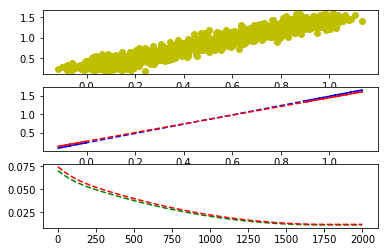

In [2]:
seed = 42
n, a, b = 1000, 1.24, 0.24
x, y = L.data_generator(n, lambda x: a *x + b, 0.0, 1.0, sigma=0.005)
a_, b_, train_loss, test_loss = L.linear_regressor((x, y), lr=0.0005, max_iter=2000, split_ratio=0.7, verbose=True)

f = lambda x: a * x + b
f_ = lambda x: a_ * x + b_

plt.figure(2)
plt.subplot(311)
plt.plot(x, y, 'yo')
plt.subplot(312)
plt.plot(x, f(x), 'b--', x, f_(x), 'r--')
plt.subplot(313)
train_loss_x = [temp[0] for temp in train_loss]
train_loss_y = [temp[1] for temp in train_loss]

test_loss_x = [temp[0] for temp in test_loss]
test_loss_y = [temp[1] for temp in test_loss]

plt.plot(train_loss_x, train_loss_y, 'g--', test_loss_x, test_loss_y, 'r--')

plt.show()

### Regularly used functions

In [4]:
def data_set_generator(n, fn, num_datasets, x_min, x_max, sigmas):
    print("Generating data sets.")
    data_sets = {}
    for sigma in sigmas:
        data_sets[sigma] = []
        print("Sigma:" + str(sigma))
        for i in range(num_datasets):
            x, y = L.data_generator(n, fn, x_min, x_max, sigma=sigma)
            data_sets[sigma].append((x, y))
            if (i + 1) % (num_datasets // 5) == 0:
                print("Generating: [%d%%]\r" %int(100*(i + 1)/num_datasets), end="")
        print("")
    return data_sets

In [5]:
def fit_linear_models(data_sets, lr, max_iter, split_ratio):
    sigmas = data_sets.keys()
    thetas = {}
    
    for sigma in sigmas:
        thetas[sigma] = []
        print("Sigma:" + str(sigma))
        for i, data in enumerate(data_sets[sigma]):
            a, b, _, _ = L.linear_regressor(data, lr=lr, max_iter=max_iter, split_ratio=split_ratio, verbose=False)
            thetas[sigma].append((a, b))
            if (i + 1) % (len(data_sets[sigma]) // 20) == 0:
                print("Fitting: [%d%%]\r" %int(100*(i + 1)/len(data_sets[sigma])), end="")
        print("")
    return thetas

In [6]:
def fit_polynomials(data_sets, degrees, x_test):
    ys_pred = {}
    for degree in degrees:
        ys_pred[degree] = []
        print("Degree:" + str(degree))
        for i, data in enumerate(data_sets):
            poly = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.0))
            poly.fit(data[0].reshape((-1, 1)), data[1])
            y_test = poly.predict(x_test)
            ys_pred[degree].append(y_test[0])
            if (i + 1) % (len(data_sets) // 20) == 0:
                print("Fitting: [%d%%]\r" %int(100*(i + 1)/len(data_sets)), end="")
        print("")
    return ys_pred

**Experiment:** n = 10, number of datasets: 10000

In [7]:
n = 10
a = 0.86
b = 0.13
num_datasets = 2000
x_min = 0.0
x_max = 1.0
sigmas = [0.02, 0.01, 0.002]

data_sets = data_set_generator(n, lambda x: a * x + b, num_datasets, x_min, x_max, sigmas)

Generating data sets.
Sigma:0.02
Generating: [100%]
Sigma:0.01
Generating: [100%]
Sigma:0.002
Generating: [100%]


Plot a data set as an example with the right linear model

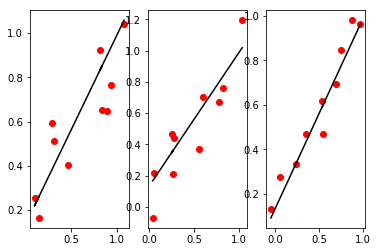

In [8]:
f = lambda x: a * x + b
plt.figure(1)
for i in range(3):
    plt.subplot(130 + i + 1)
    x = data_sets[sigmas[i]][0][0]
    y = data_sets[sigmas[i]][0][1]
    plt.plot(x, y, 'ro', x, f(x), 'k')
plt.show()

### Bias-variance for model complexity

In [39]:
# generating data
n = 15
a = 1.21
b = 0.63
fn = lambda x: a * x**4 + b
num_datasets = 200
x_min = 0.0
x_max = 1.0
sigmas = [0.01, 0.005, 0.001]

data_sets = data_set_generator(n, fn, num_datasets, x_min, x_max, sigmas)

Generating data sets.
Sigma:0.01
Generating: [100%]
Sigma:0.005
Generating: [100%]
Sigma:0.001
Generating: [100%]


In [40]:
# fitting polynomials with different degrees
degrees = [1, 2, 4, 6, 8, 10]
x_test = 0.53
ys_pred = fit_polynomials(data_sets[sigmas[0]], degrees, x_test)

Degree:1
Fitting: [100%]
Degree:2
Fitting: [100%]
Degree:4
Fitting: [100%]
Degree:6
Fitting: [100%]
Degree:8
Fitting: [100%]
Degree:10
Fitting: [100%]


In [41]:
# calculating the bias and variance
y = fn(x_test)

bias = []
var = []
for degree in degrees:
    b, v = L.bias_var(np.array(ys_pred[degree]), y)
    bias.append(b)
    var.append(v)

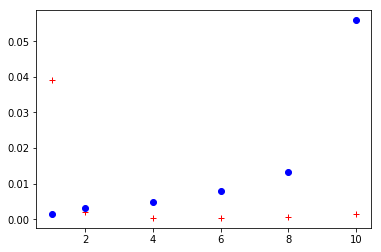

In [42]:
plt.figure(3)
plt.plot(degrees, bias, 'r+', degrees, var, 'bo')
plt.show()